# Queue Framework Demo & Walkthrough

This notebook demonstrates the use of the `queue_framework`, a lightweight, zero-dependency Python library for simulating resource-queue systems within a Discrete Event Simulator (DES).

### Purpose

The framework is intentionally "headless" — it **does not manage time**. It only manages **state** (who is being served, who is waiting) and **KPIs** (wait times, utilization, etc.).

This notebook will:
1.  **Build a simple DES engine** (a "mini-simulator") to manage time and events.
2.  **Test the `FIFOQueueModel`** (a standard G/G/c queue).
3.  **Test the `PriorityQueueModel`** to show how its logic differs and how it tracks *extended KPIs* (stats per priority).
4.  **Test the `FiniteCapacityModel`** to show its "balking" (rejection) logic.
5.  **Demonstrate transient analysis** (warm-up detection) using the built-in `analysis` package.

We will configure Python's `logging` to see the detailed `DEBUG` messages printed by the framework as it processes events.

In [1]:
# Cella 2: Imports and Logging Setup

import heapq
import random
import logging
import sys
import pprint
import matplotlib.pyplot as plt

# Import our Queue Framework
try:
    from queue_framework import (
        BaseQueueModel,
        FIFOQueueModel,
        PriorityQueueModel,
        FiniteCapacityModel,
        EntityState,
        RequestResult
    )
    from queue_framework.analysis import (
        plot_queue_length_over_time,
        plot_server_utilization_over_time,
        plot_system_time_histogram,
        plot_wait_time_histogram,
        plot_transient_analysis,
        plot_batch_means_over_time
    )

    from queue_framework.analysis import (
        calculate_transient_data,
        find_transient_end
    )

except ImportError:
    print("="*80)
    print("ERROR: Could not import queue_framework.")
    print("Please ensure you have installed it correctly, e.g., by running:")
    print('pip install -e ".[analysis,examples]"')
    print("from the root directory of this project.")
    print("="*80)
    raise

# Configure Logging
# This "activates" the logs from our framework, which are
# normally silenced by the library's NullHandler.
# We set the level to DEBUG to see everything.

logging.basicConfig(
    level=logging.DEBUG,
    format='[%(asctime)s] %(levelname)-8s %(name)-25s: %(message)s',
    datefmt='%H:%M:%S',
    stream=sys.stdout,
)

# Set matplotlib logging to WARNING to reduce verbosity
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.getLogger('matplotlib.font_manager').setLevel(logging.WARNING)

# We can also create a logger for this notebook itself
log = logging.getLogger("SimulationDemo")
logging.getLogger("SimulationDemo").setLevel(logging.INFO) 

log.info("--- Simulation Notebook Started ---")
log.info("Framework classes imported successfully.")

# Helper for pretty-printing results
pp = pprint.PrettyPrinter(indent=2)

[17:44:17] INFO     SimulationDemo           : --- Simulation Notebook Started ---
[17:44:17] INFO     SimulationDemo           : Framework classes imported successfully.


## The Mini-DES Engine

As mentioned, our framework needs an external simulator. We'll define a simple one below. It's not part of the framework, but it's necessary to *run* the demo.

It consists of three main parts:
* **`Entity`**: The "customer" or "item" that moves through the system. It *must* have a `.state` and `.priority` attribute to satisfy the framework's "contract".
* **`Event`**: A base class for things that happen at a specific time (`ArrivalEvent`, `EndServiceEvent`).
* **`Simulation`**: The engine that holds the `BaseQueueModel`, manages the clock, and processes events from a Future Event List (FEL).

In [2]:
class Entity:
    """A simple entity to be processed by the queue model."""
    _id_counter = 0
    
    def __init__(self, arrival_time: float, priority: int = 1):
        self.id: int = Entity._id_counter
        Entity._id_counter += 1
        
        # --- Framework Contract ---
        # The framework expects entities to have these attributes.
        self.state: EntityState = EntityState.IDLE
        self.priority: int = priority
        # --------------------------
        
        self.arrival_time: float = arrival_time
        
    def __repr__(self):
        return f"Entity(id={self.id}, p={self.priority})"
    
    # We make the entity hashable so it can be stored in sets/dicts
    def __hash__(self):
        return hash(self.id)
    
    def __eq__(self, other):
        return isinstance(other, Entity) and self.id == other.id

In [3]:
class Event:
    """Base class for all events, sortable by time."""
    def __init__(self, time: float):
        self.time: float = time
    
    # This dunder method allows heapq to sort events by time
    def __lt__(self, other):
        return self.time < other.time

class ArrivalEvent(Event):
    """An event representing a new entity arriving at the system."""
    def __init__(self, time: float, entity: Entity):
        super().__init__(time)
        self.entity: Entity = entity
        
    def __repr__(self):
        return f"Arrival(T={self.time:.2f}, {self.entity})"

class EndServiceEvent(Event):
    """An event representing an entity finishing service."""
    def __init__(self, time: float, entity: Entity):
        super().__init__(time)
        self.entity: Entity = entity

    def __repr__(self):
        return f"EndService(T={self.time:.2f}, {self.entity})"

In [4]:
class Simulation:
    """Manages the simulation clock and Future Event List (FEL)."""
    
    def __init__(self, model: BaseQueueModel):
        self.fel: list = []  # Future Event List (a min-heap)
        self.clock: float = 0.0
        
        # This is the key: the engine holds a reference
        # to an instance of our framework's model.
        self.model: BaseQueueModel = model
        
        # Simulation parameters (will be set by helper)
        self.avg_service_time: float = 1.0

    def schedule(self, event: Event):
        """Add an event to the Future Event List."""
        heapq.heappush(self.fel, event)
        
    def run(self, max_time: float):
        """Run the simulation until the FEL is empty or max_time is reached."""
        
        log.info(f"Simulation started. Running until T={max_time:.2f}")
        Entity._id_counter = 0 # Reset entity IDs for each run
        
        while self.fel:
            # Get the next event
            event = heapq.heappop(self.fel)
            
            # Check stop condition
            if event.time > max_time:
                log.info(f"Stopping simulation at max_time={max_time:.2f}")
                self.fel.clear() # Clear remaining events
                break
                
            # Advance Clock
            if event.time < self.clock:
                # NOTE: This should not happen in a simple simulation
                log.warning(f"Event {event} is in the past! (T={event.time})")
            
            self.clock = event.time
            
            # Process Event
            self.handle_event(event)
            
        log.info(f"--- Simulation finished at T={self.clock:.2f} ---")
        
        # === Get Final KPIs from the framework ===
        return self.model.get_final_kpis(self.clock)

    def handle_event(self, event: Event):
        """The main simulation logic."""
        
        if isinstance(event, ArrivalEvent):
            # Handle an ARRIVAL
            log.debug(f"[EVENT] Arrival at T={self.clock:.2f} for {event.entity}")
            
            # === INTERACTION WITH FRAMEWORK (1/3) ===
            result = self.model.request(event.entity, self.clock)
            # ========================================
            
            if result == RequestResult.SERVED_IMMEDIATELY:
                # The entity got a resource. We must schedule
                # its future EndServiceEvent.
                self.schedule_end_service(event.entity)
            
            elif result == RequestResult.QUEUED:
                # The entity is waiting. The model will handle it.
                pass
            
            elif result == RequestResult.REJECTED_QUEUE_FULL:
                # The entity was rejected.
                log.debug(f"Entity {event.entity} was REJECTED by model.")
                pass
                
        elif isinstance(event, EndServiceEvent):
            # Handle an END OF SERVICE
            log.debug(f"[EVENT] EndService at T={self.clock:.2f} for {event.entity}")
            
            # === INTERACTION WITH FRAMEWORK (2/3) ===
            next_entity = self.model.release(event.entity, self.clock)
            # ========================================
            
            if next_entity:
                # The model just served a new entity from the queue.
                # We must schedule its EndServiceEvent.
                log.debug(f"Model served {next_entity} from queue.")
                self.schedule_end_service(next_entity)

    def schedule_end_service(self, entity: Entity):
        """Helper to create a new EndServiceEvent."""
        service_time = random.expovariate(1.0 / self.avg_service_time)
        end_time = self.clock + service_time
        
        self.schedule(EndServiceEvent(end_time, entity))

In [5]:
def run_simulation(
    model: BaseQueueModel,
    num_arrivals: int,
    avg_interarrival_time: float,
    avg_service_time: float,
    max_sim_time: float = 10000.0,
    priority_fn=None
):
    """
    Sets up and runs a simulation with the given model and parameters.
    
    Args:
        model: The instantiated queue_framework model to test.
        num_arrivals: The total number of entities to create.
        avg_interarrival_time: The average time between arrivals (for expovariate).
        avg_service_time: The average time for service (for expovariate).
        max_sim_time: The simulation clock time to stop at.
        priority_fn: A function that returns a priority for an entity.
                     If None, defaults to 1.
    """
    
    log.info(f"--- Setting up new simulation for {type(model).__name__} ---")
    
    sim = Simulation(model)
    sim.avg_service_time = avg_service_time

    # Create and schedule all initial arrival events
    current_time = 0.0
    for _ in range(num_arrivals):
        # Calculate arrival time
        current_time += random.expovariate(1.0 / avg_interarrival_time)
        
        # Determine priority
        priority = priority_fn() if priority_fn else 1
            
        entity = Entity(arrival_time=current_time, priority=priority)
        sim.schedule(ArrivalEvent(current_time, entity))
        
    # Run the simulation
    kpis = sim.run(max_sim_time)
    
    return kpis

log.info("DES Engine and helper function are defined.")

[17:44:17] INFO     SimulationDemo           : DES Engine and helper function are defined.


## Test 1: `FIFOQueueModel`

Let's run our first test using the standard `FIFOQueueModel`. We'll simulate a small system with **2 servers** (e.g., bank tellers) and an average arrival rate that is *close* to the service rate, which should create a queue.

* **Model**: `FIFOQueueModel(capacity=2)`
* **Arrivals**: Avg. 3 time units apart
* **Service**: Avg. 5 time units long

This setup has a traffic intensity ($\lambda/\mu$) of (1/3) / (1/5) * (1/2 servers) = 0.83, so the system should be stable.

In [6]:
# Instantiate the model from our framework
fifo_model = FIFOQueueModel(capacity=2, start_time=0.0)

# Define simulation parameters
params = {
    "model": fifo_model,
    "num_arrivals": 500,
    "avg_interarrival_time": 3.0,
    "avg_service_time": 5.0,
    "max_sim_time": 2000.0
}

# Run the simulation
# (We'll set the logging level to INFO just for the run
# to avoid flooding the output. Set to DEBUG to see all events)
logging.getLogger("queue_framework").setLevel(logging.INFO)
log.info("--- Starting FIFO Model Run ---")

fifo_kpis = run_simulation(**params)

logging.getLogger("queue_framework").setLevel(logging.DEBUG)
log.info("--- FIFO Model Run Complete ---")

# 4. Print the final KPIs
print("\n" + "="*50)
print("     FINAL KPIs for FIFOQueueModel")
print("="*50)
pp.pprint(fifo_kpis)

[17:44:17] DEBUG    queue_framework.measure  : Measure tracker initialized (Capacity=2, StartTime=0.0)
[17:44:17] INFO     queue_framework.models.fifo_model: FIFOQueueModel initialized: Capacity=2, StartTime=0.00
[17:44:17] INFO     SimulationDemo           : --- Starting FIFO Model Run ---
[17:44:17] INFO     SimulationDemo           : --- Setting up new simulation for FIFOQueueModel ---
[17:44:17] INFO     SimulationDemo           : Simulation started. Running until T=2000.00
[17:44:17] INFO     SimulationDemo           : --- Simulation finished at T=1635.89 ---
[17:44:17] INFO     queue_framework.models.fifo_model: Calculating final KPIs at T=1635.89
[17:44:17] INFO     queue_framework.measure  : Calculating final KPIs for total duration: 1635.89 (from 0.00 to 1635.89)
[17:44:17] INFO     SimulationDemo           : --- FIFO Model Run Complete ---

     FINAL KPIs for FIFOQueueModel
{ 'arrivals_and_throughput': { 'probability_of_waiting': 0.62,
                               'total_a

[17:44:17] INFO     SimulationDemo           : Generating plots for FIFOQueueModel...
[17:44:17] INFO     queue_framework.measure  : Calculating final KPIs for total duration: 1635.89 (from 0.00 to 1635.89)
[17:44:17] DEBUG    queue_framework.analysis.plotting: Plotted wait time histogram (n=500)
[17:44:17] INFO     queue_framework.measure  : Calculating final KPIs for total duration: 1635.89 (from 0.00 to 1635.89)
[17:44:17] DEBUG    queue_framework.analysis.plotting: Plotted system time histogram (n=500)
[17:44:17] INFO     queue_framework.measure  : Calculating final KPIs for total duration: 1635.89 (from 0.00 to 1635.89)
[17:44:17] DEBUG    queue_framework.analysis.plotting: Plotted queue length over time.
[17:44:17] INFO     queue_framework.measure  : Calculating final KPIs for total duration: 1635.89 (from 0.00 to 1635.89)
[17:44:17] DEBUG    queue_framework.analysis.plotting: Plotted server utilization over time.


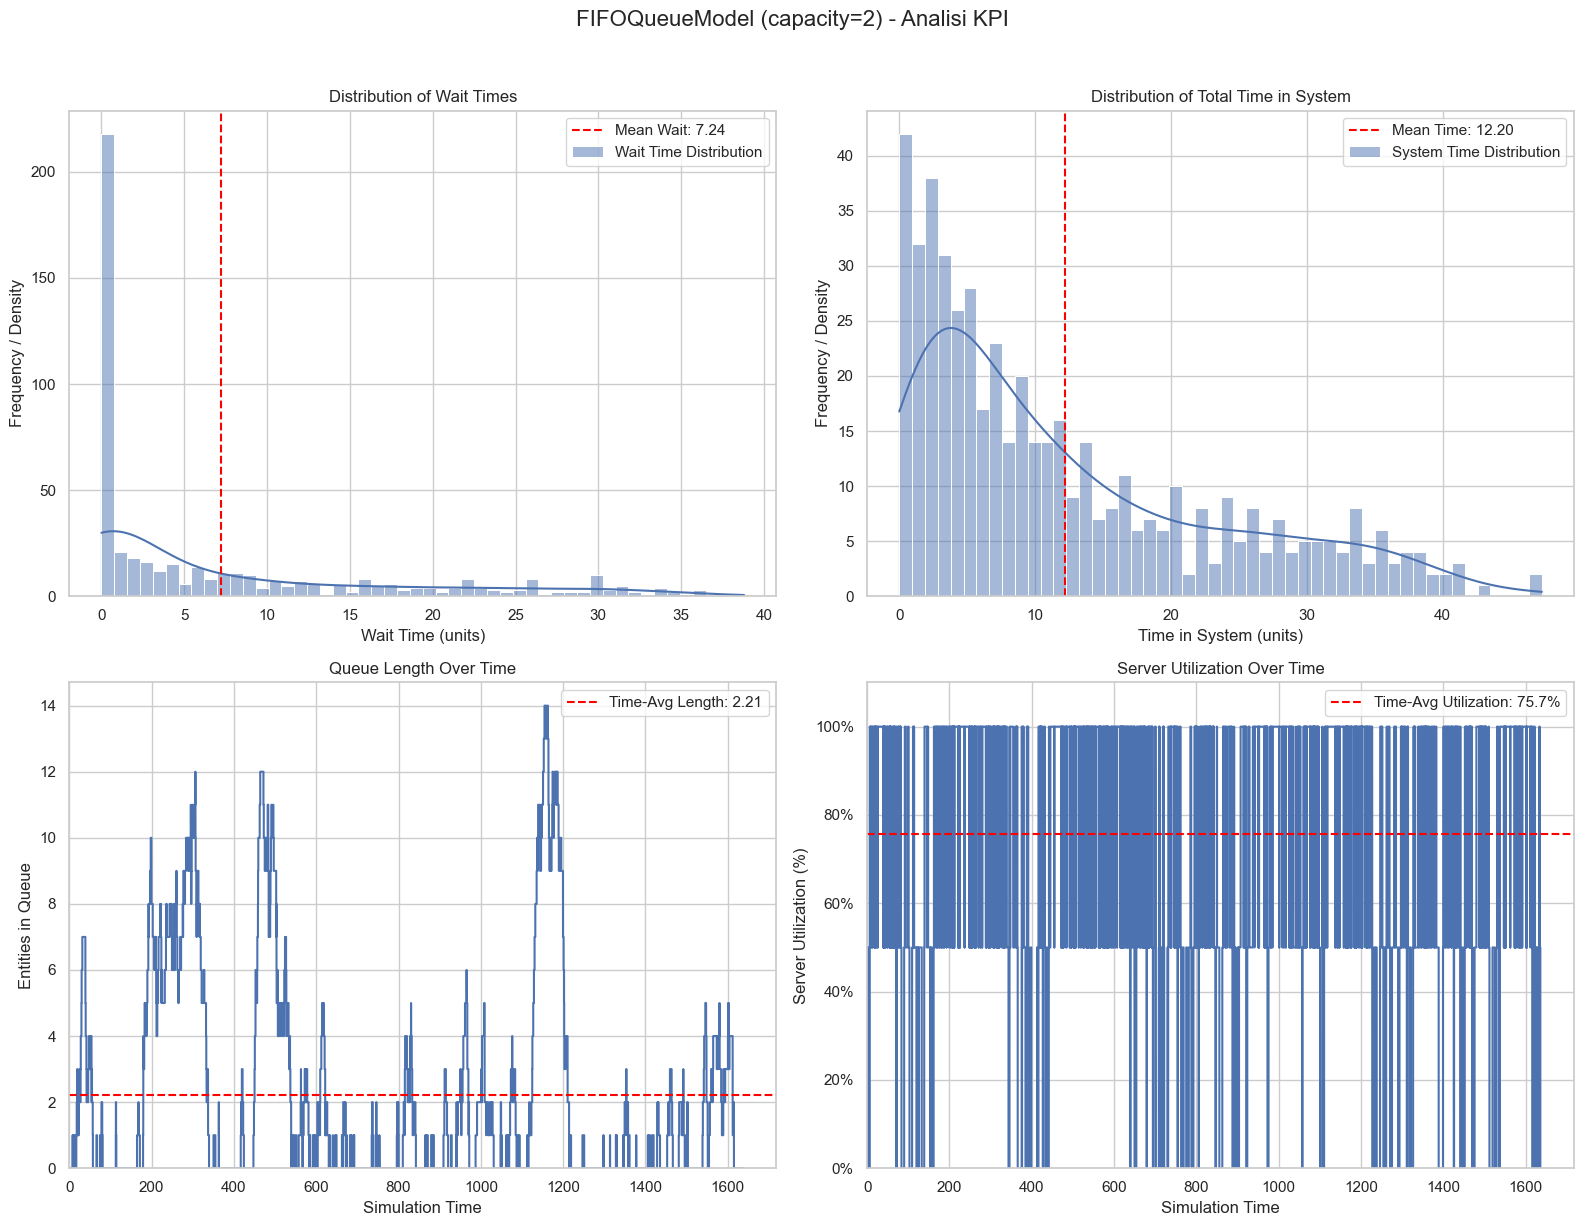

In [7]:
log.info("Generating plots for FIFOQueueModel...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("FIFOQueueModel (capacity=2) - Analisi KPI", fontsize=16, y=1.02)

measure_obj = fifo_model.kpi_tracker

# Wait Time Histogram
plot_wait_time_histogram(measure_obj, ax=axes[0, 0])

# System Time Histogram
plot_system_time_histogram(measure_obj, ax=axes[0, 1])

# Queue Length Over Time
plot_queue_length_over_time(measure_obj, ax=axes[1, 0])

# Server Utilization Over Time
plot_server_utilization_over_time(measure_obj, ax=axes[1, 1], as_percentage=True)

plt.tight_layout()
plt.show()

## Test 2: `PriorityQueueModel`

Now, let's test the `PriorityQueueModel`. We will use the **exact same DES engine**. The only change is the model instance we pass to it.

We'll simulate an IT help desk where requests are:
* `priority=1` (High - e.g., "server down")
* `priority=5` (Low - e.g., "mouse broken")

**Look for the `priority_breakdown` section** in the final KPI report.

In [8]:
# Instantiate the model
priority_model = PriorityQueueModel(capacity=2, start_time=0.0)

# Define a priority function
def get_priority():
    # 20% are high priority, 80% are low priority
    return 1 if random.random() < 0.2 else 5

# Define simulation parameters (same as before)
params = {
    "model": priority_model,
    "num_arrivals": 500,
    "avg_interarrival_time": 3.0,
    "avg_service_time": 5.0,
    "max_sim_time": 2000.0,
    "priority_fn": get_priority
}

# Run the simulation
logging.getLogger("queue_framework").setLevel(logging.INFO)
log.info("--- Starting Priority Model Run ---")

priority_kpis = run_simulation(**params)

logging.getLogger("queue_framework").setLevel(logging.DEBUG)
log.info("--- Priority Model Run Complete ---")

# Print the final KPIs
print("\n" + "="*50)
print("   FINAL KPIs for PriorityQueueModel")
print("="*50)
pp.pprint(priority_kpis)

[17:44:17] DEBUG    queue_framework.measure  : Measure tracker initialized (Capacity=2, StartTime=0.0)
[17:44:17] INFO     queue_framework.models.priority_model: PriorityQueueModel initialized: Capacity=2, StartTime=0.00
[17:44:17] INFO     SimulationDemo           : --- Starting Priority Model Run ---
[17:44:17] INFO     SimulationDemo           : --- Setting up new simulation for PriorityQueueModel ---
[17:44:17] INFO     SimulationDemo           : Simulation started. Running until T=2000.00
[17:44:17] INFO     SimulationDemo           : --- Simulation finished at T=1508.66 ---
[17:44:17] INFO     queue_framework.models.priority_model: Calculating final KPIs at T=1508.66
[17:44:17] INFO     queue_framework.measure  : Calculating final KPIs for total duration: 1508.66 (from 0.00 to 1508.66)
[17:44:17] INFO     queue_framework.measure  : Calculating final KPIs for total duration: 1508.66 (from 0.00 to 1508.66)
[17:44:17] INFO     queue_framework.measure  : Calculating final KPIs for to

[17:44:17] INFO     SimulationDemo           : Generating plots for PriorityQueueModel...
[17:44:17] INFO     queue_framework.measure  : Calculating final KPIs for total duration: 1508.66 (from 0.00 to 1508.66)
[17:44:17] DEBUG    queue_framework.analysis.plotting: Plotted wait time histogram (n=500)
[17:44:17] INFO     queue_framework.measure  : Calculating final KPIs for total duration: 1508.66 (from 0.00 to 1508.66)
[17:44:17] DEBUG    queue_framework.analysis.plotting: Plotted system time histogram (n=500)
[17:44:17] INFO     queue_framework.measure  : Calculating final KPIs for total duration: 1508.66 (from 0.00 to 1508.66)
[17:44:17] DEBUG    queue_framework.analysis.plotting: Plotted queue length over time.
[17:44:17] INFO     queue_framework.measure  : Calculating final KPIs for total duration: 1508.66 (from 0.00 to 1508.66)
[17:44:17] DEBUG    queue_framework.analysis.plotting: Plotted server utilization over time.


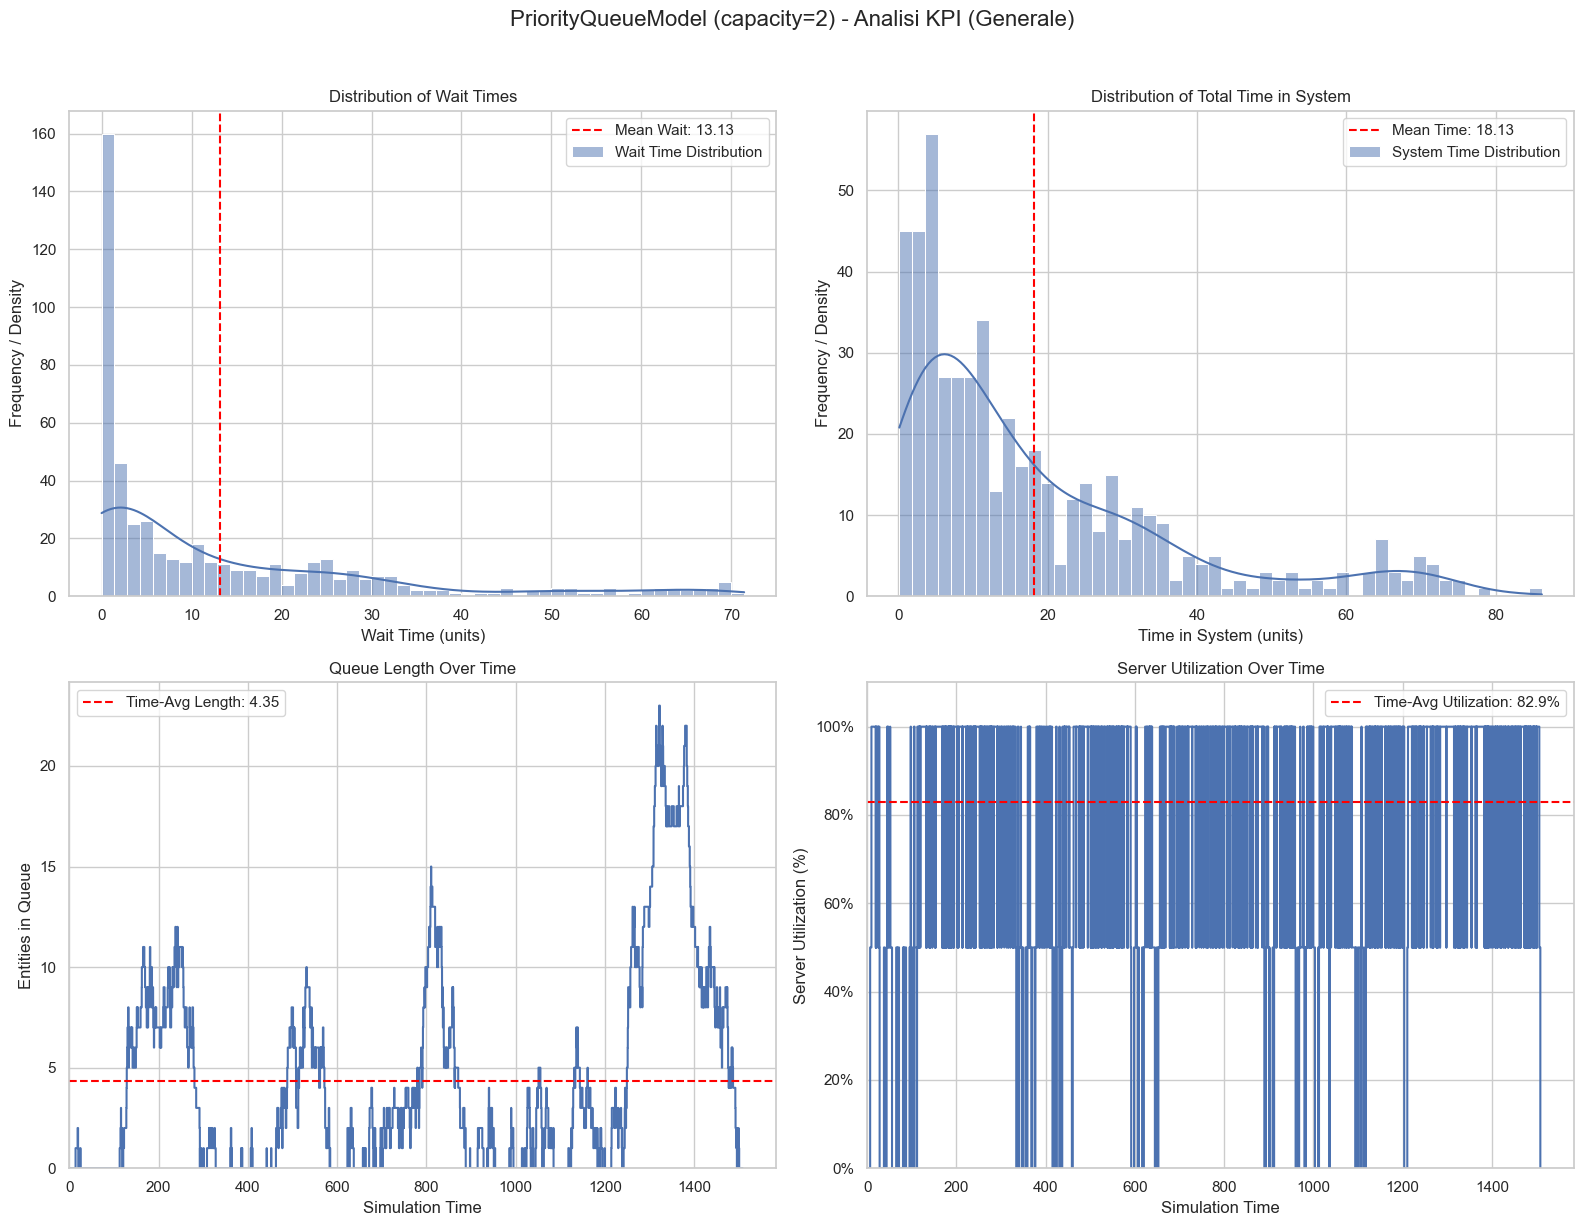

[17:44:18] INFO     SimulationDemo           : Plotting wait times for priority 1...
[17:44:18] INFO     queue_framework.measure  : Calculating final KPIs for total duration: 1492.40 (from 0.00 to 1492.40)
[17:44:18] DEBUG    queue_framework.analysis.plotting: Plotted wait time histogram (n=96)
[17:44:18] INFO     SimulationDemo           : Plotting wait times for priority 5...
[17:44:18] INFO     queue_framework.measure  : Calculating final KPIs for total duration: 1508.66 (from 0.00 to 1508.66)
[17:44:18] DEBUG    queue_framework.analysis.plotting: Plotted wait time histogram (n=404)


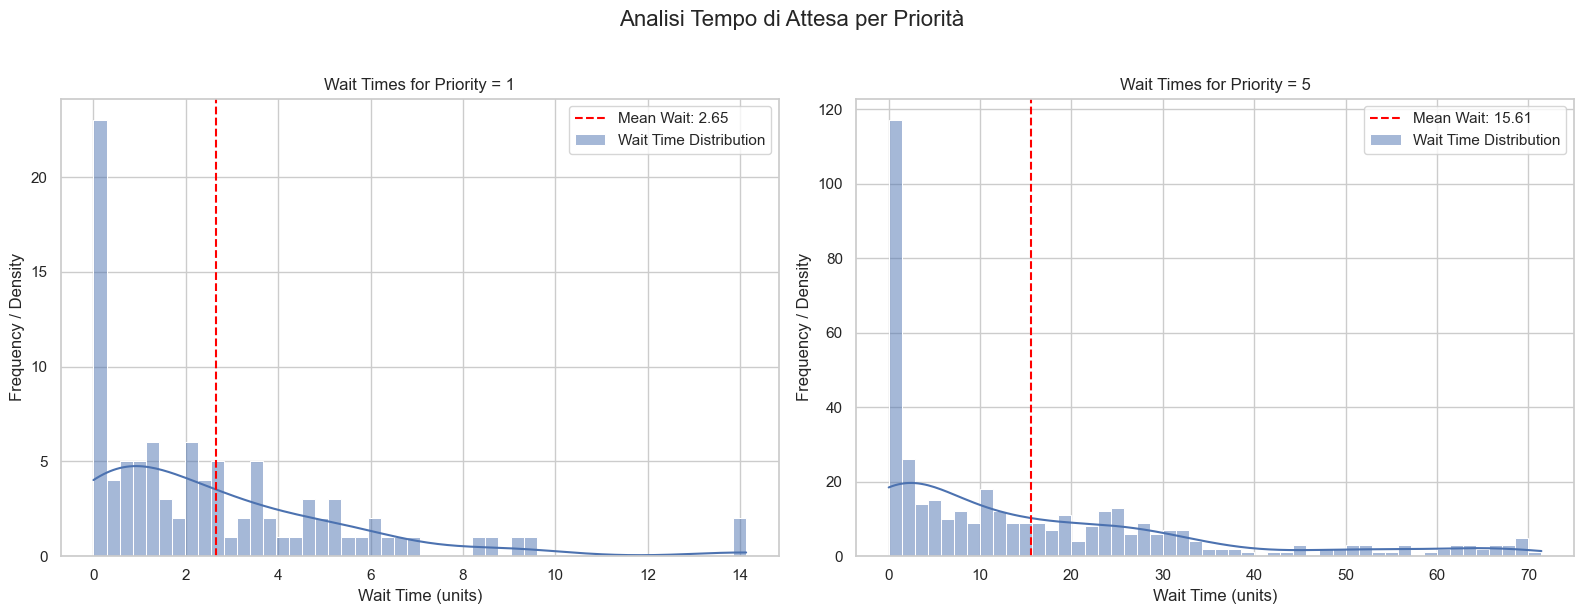

In [9]:
log.info("Generating plots for PriorityQueueModel...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("PriorityQueueModel (capacity=2) - Analisi KPI (Generale)", fontsize=16, y=1.02)

measure_obj = priority_model.kpi_tracker

# Wait Time Histogram
plot_wait_time_histogram(measure_obj, ax=axes[0, 0])

# System Time Histogram
plot_system_time_histogram(measure_obj, ax=axes[0, 1])

# Queue Length Over Time
plot_queue_length_over_time(measure_obj, ax=axes[1, 0])

# Server Utilization Over Time
plot_server_utilization_over_time(measure_obj, ax=axes[1, 1], as_percentage=True)

plt.tight_layout()
plt.show()

# Plot KPI extension
priority_trackers = priority_model.priority_kpi_trackers
priorities = sorted(priority_trackers.keys())

fig, axes = plt.subplots(1, len(priorities), figsize=(8 * len(priorities), 6), squeeze=False)
fig.suptitle("Analisi Tempo di Attesa per Priorità", fontsize=16, y=1.02)

for i, p in enumerate(priorities):
    log.info(f"Plotting wait times for priority {p}...")
    p_measure = priority_trackers[p]
    ax = axes[0, i]
    plot_wait_time_histogram(p_measure, ax=ax)
    ax.set_title(f"Wait Times for Priority = {p}")

plt.tight_layout()
plt.show()

## Test 3: `FiniteCapacityModel`

Finally, let's test the `FiniteCapacityModel`. We'll simulate a call center with **2 agents** (`capacity=2`) and a waiting line that can only hold **3 people** (`queue_capacity=3`).

We will use a high arrival rate (avg. 2 time units) to *force* the queue to fill up, which should cause rejections.

**Look for the `total_rejections`** in the `arrivals_and_throughput` section.

In [10]:
# Instantiate the model
finite_model = FiniteCapacityModel(
    capacity=2,
    queue_capacity=3,
    start_time=0.0
)

# Define simulation parameters
params = {
    "model": finite_model,
    "num_arrivals": 500,
    "avg_interarrival_time": 2.0,
    "avg_service_time": 5.0,
    "max_sim_time": 2000.0
}

# Run the simulation
logging.getLogger("queue_framework").setLevel(logging.DEBUG)
log.info("--- Starting Finite Capacity Model Run ---")

finite_kpis = run_simulation(**params)

log.info("--- Finite Capacity Model Run Complete ---")

# Print the final KPIs
print("\n" + "="*50)
print("  FINAL KPIs for FiniteCapacityModel")
print("="*50)
pp.pprint(finite_kpis)

[17:44:18] DEBUG    queue_framework.measure  : Measure tracker initialized (Capacity=2, StartTime=0.0)
[17:44:18] INFO     queue_framework.models.finite_capacity_model: FiniteCapacityModel initialized: Capacity=2, QueueCapacity=3, StartTime=0.00
[17:44:18] INFO     SimulationDemo           : --- Starting Finite Capacity Model Run ---
[17:44:18] INFO     SimulationDemo           : --- Setting up new simulation for FiniteCapacityModel ---
[17:44:18] INFO     SimulationDemo           : Simulation started. Running until T=2000.00
[17:44:18] DEBUG    queue_framework.models.finite_capacity_model: T=3.70: Request from entity Entity(id=0, p=1)...
[17:44:18] DEBUG    queue_framework.measure  : T=3.70: Entity arrival logged. Total arrivals: 1
[17:44:18] DEBUG    queue_framework.models.finite_capacity_model: T=3.70: Resource available for Entity(id=0, p=1).
[17:44:18] DEBUG    queue_framework.measure  : T=3.70: Entity service started. Wait: 0.00, Q_len: 0, Busy: 1
[17:44:18] DEBUG    queue_framew

[17:44:23] INFO     SimulationDemo           : Generating plots for FiniteCapacityModel...
[17:44:23] INFO     queue_framework.measure  : Calculating final KPIs for total duration: 1019.01 (from 0.00 to 1019.01)
[17:44:23] DEBUG    queue_framework.analysis.plotting: Plotted wait time histogram (n=356)
[17:44:23] INFO     queue_framework.measure  : Calculating final KPIs for total duration: 1019.01 (from 0.00 to 1019.01)
[17:44:23] DEBUG    queue_framework.analysis.plotting: Plotted system time histogram (n=356)
[17:44:23] INFO     queue_framework.measure  : Calculating final KPIs for total duration: 1019.01 (from 0.00 to 1019.01)
[17:44:23] DEBUG    queue_framework.analysis.plotting: Plotted queue length over time.
[17:44:23] INFO     queue_framework.measure  : Calculating final KPIs for total duration: 1019.01 (from 0.00 to 1019.01)
[17:44:23] DEBUG    queue_framework.analysis.plotting: Plotted server utilization over time.


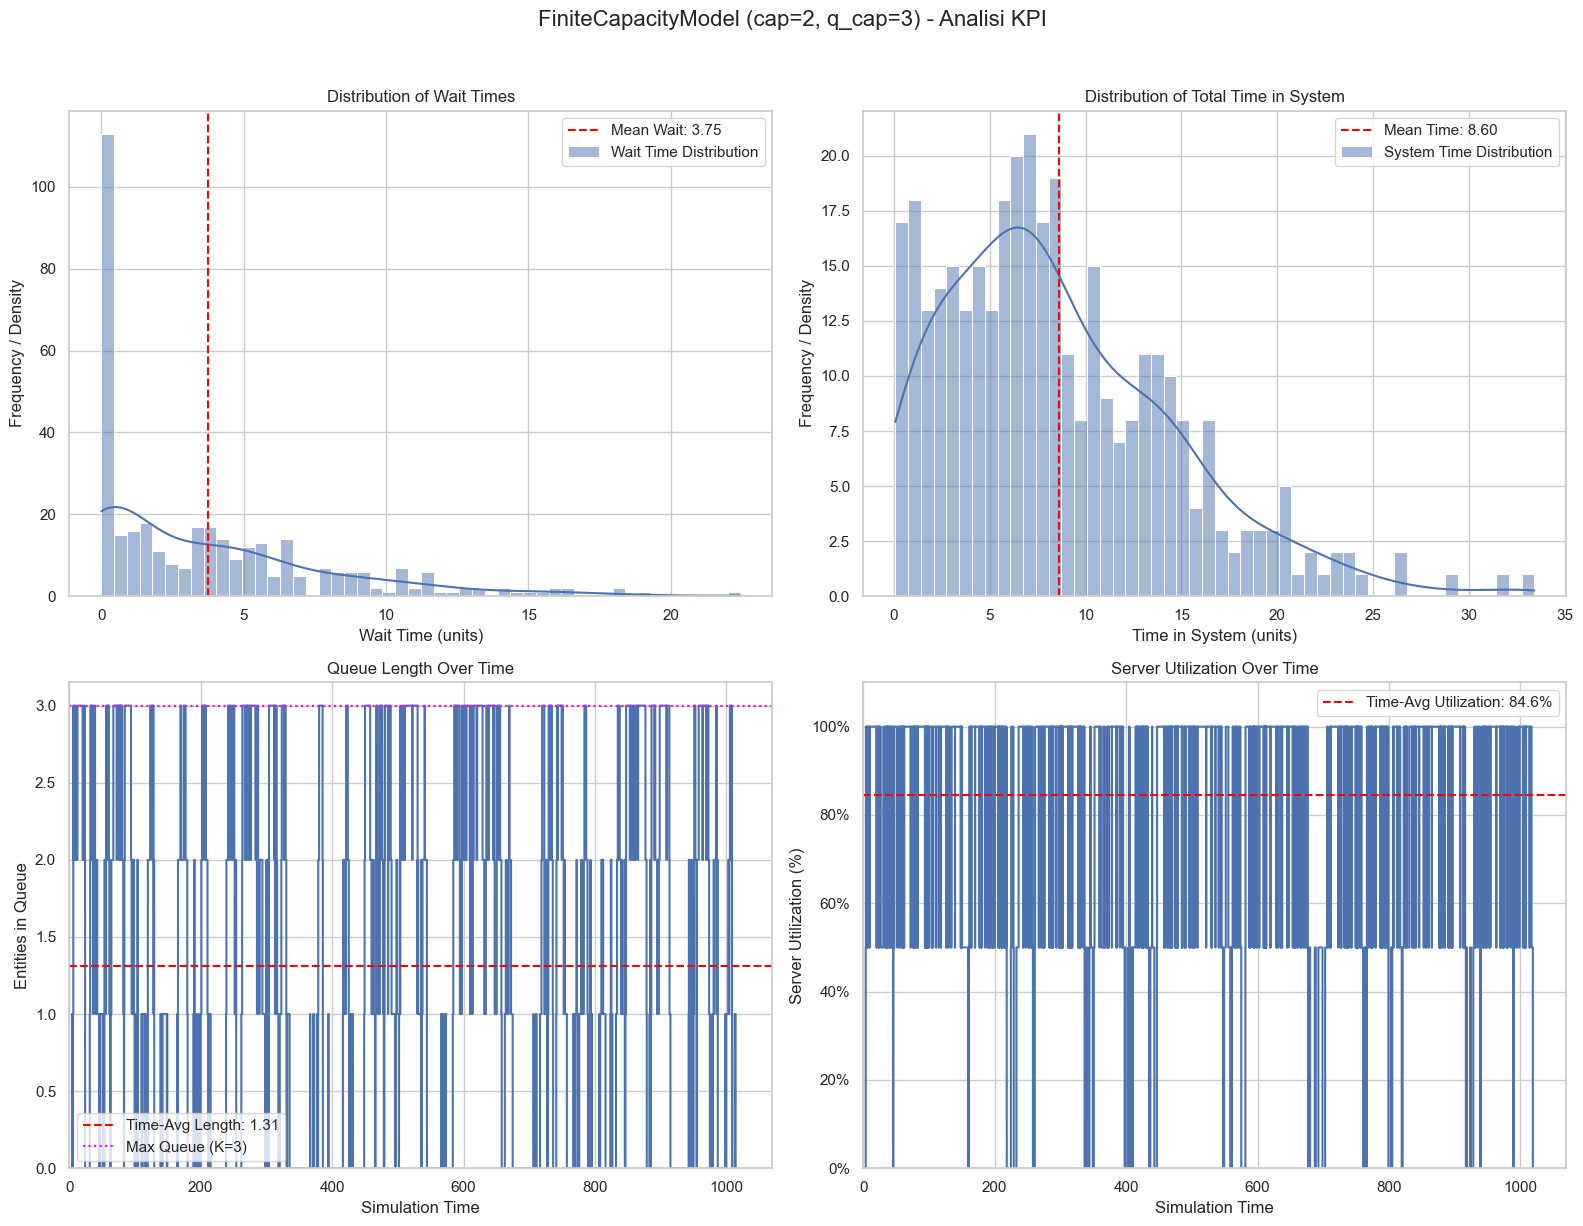

In [11]:
log.info("Generating plots for FiniteCapacityModel...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("FiniteCapacityModel (cap=2, q_cap=3) - Analisi KPI", fontsize=16, y=1.02)

measure_obj = finite_model.kpi_tracker

# Wait Time Histogram
plot_wait_time_histogram(measure_obj, ax=axes[0, 0])

# System Time Histogram
plot_system_time_histogram(measure_obj, ax=axes[0, 1])

# Queue Length Over Time
plot_queue_length_over_time(measure_obj, ax=axes[1, 0])

# Queue Limit Line
axes[1, 0].axhline(finite_model.queue_capacity, color='magenta', linestyle=':', label=f"Max Queue (K={finite_model.queue_capacity})")
axes[1, 0].legend()


# Server Utilization Over Time
plot_server_utilization_over_time(measure_obj, ax=axes[1, 1], as_percentage=True)

plt.tight_layout()
plt.show()

## Advanced Analysis: Automatic Transient Detection

The final step in a professional simulation study is to ensure that KPIs are calculated *after* the system has reached a stable state (steady-state). The initial "warm-up" period, known as the **transient phase**, must be identified and removed.

Our `analysis` package is designed to automate this process. We will first use the `calculate_transient_data` function from `transient.py` to process the raw simulation output into batches. Then, we will use the `find_transient_end` heuristic to **automatically find $k^*$** (the batch index where the transient phase is estimated to end).

To verify this automatic detection, we will use **two specialized plots**:

1.  **`plot_batch_means_over_time`**: This graph shows the KPI's **Moving Average** over time, allowing us to *visually* identify the transient "drift" as it happens.
2.  **`plot_transient_analysis`**: This graph shows the **Relative Error ($R_k$)** of the cumulative mean. It allows us to *quantitatively* confirm that the error converges to zero after the $k^*$ point.

To do this, we must first run a **single, very long simulation** to generate enough data for the statistical analysis.

In [12]:
log.info("--- Starting Long Run for Transient Analysis ---")

# We'll use a simple M/M/1-like system (capacity=1)
# We set rho (traffic intensity) to 0.8 to ensure it's stable.
# lambda = 1.0 (avg_interarrival_time)
# mu = 1.25 (avg_service_time = 0.8)
# rho = lambda / mu = 1.0 / 1.25 = 0.8

long_run_model = FIFOQueueModel(capacity=1)

params_long = {
    "model": long_run_model,
    "num_arrivals": 50000, 
    "avg_interarrival_time": 1.0, 
    "avg_service_time": 0.8,
    "max_sim_time": 100000.0
}

# Temporarily silence framework logs
# We set the log level to WARNING during this long run
# to avoid flooding the notebook with 50,000+ DEBUG messages.
logging.getLogger("queue_framework").setLevel(logging.WARNING)
logging.getLogger("SimulationDemo").setLevel(logging.WARNING)

log.info("Running simulation with 50,000 arrivals... (this may take a moment)")
long_run_kpis = run_simulation(**params_long)

# --- Restore log level ---
logging.getLogger("queue_framework").setLevel(logging.DEBUG)
log.info("--- Long Run Complete ---")

[17:44:24] INFO     SimulationDemo           : --- Starting Long Run for Transient Analysis ---
[17:44:24] DEBUG    queue_framework.measure  : Measure tracker initialized (Capacity=1, StartTime=0.0)
[17:44:24] INFO     queue_framework.models.fifo_model: FIFOQueueModel initialized: Capacity=1, StartTime=0.00


[17:44:26] DEBUG    queue_framework.analysis.transient: Calculating transient data for 'wait_times' with 200 batches...
[17:44:26] DEBUG    queue_framework.analysis.transient: Transient data calculation complete.
[17:44:26] DEBUG    queue_framework.analysis.transient: Heuristic found stable point at k*=0 (threshold=0.05, patience=5)
Global Mean (with transient): 3.0875
Steady-State Mean (k*=0): 3.0875


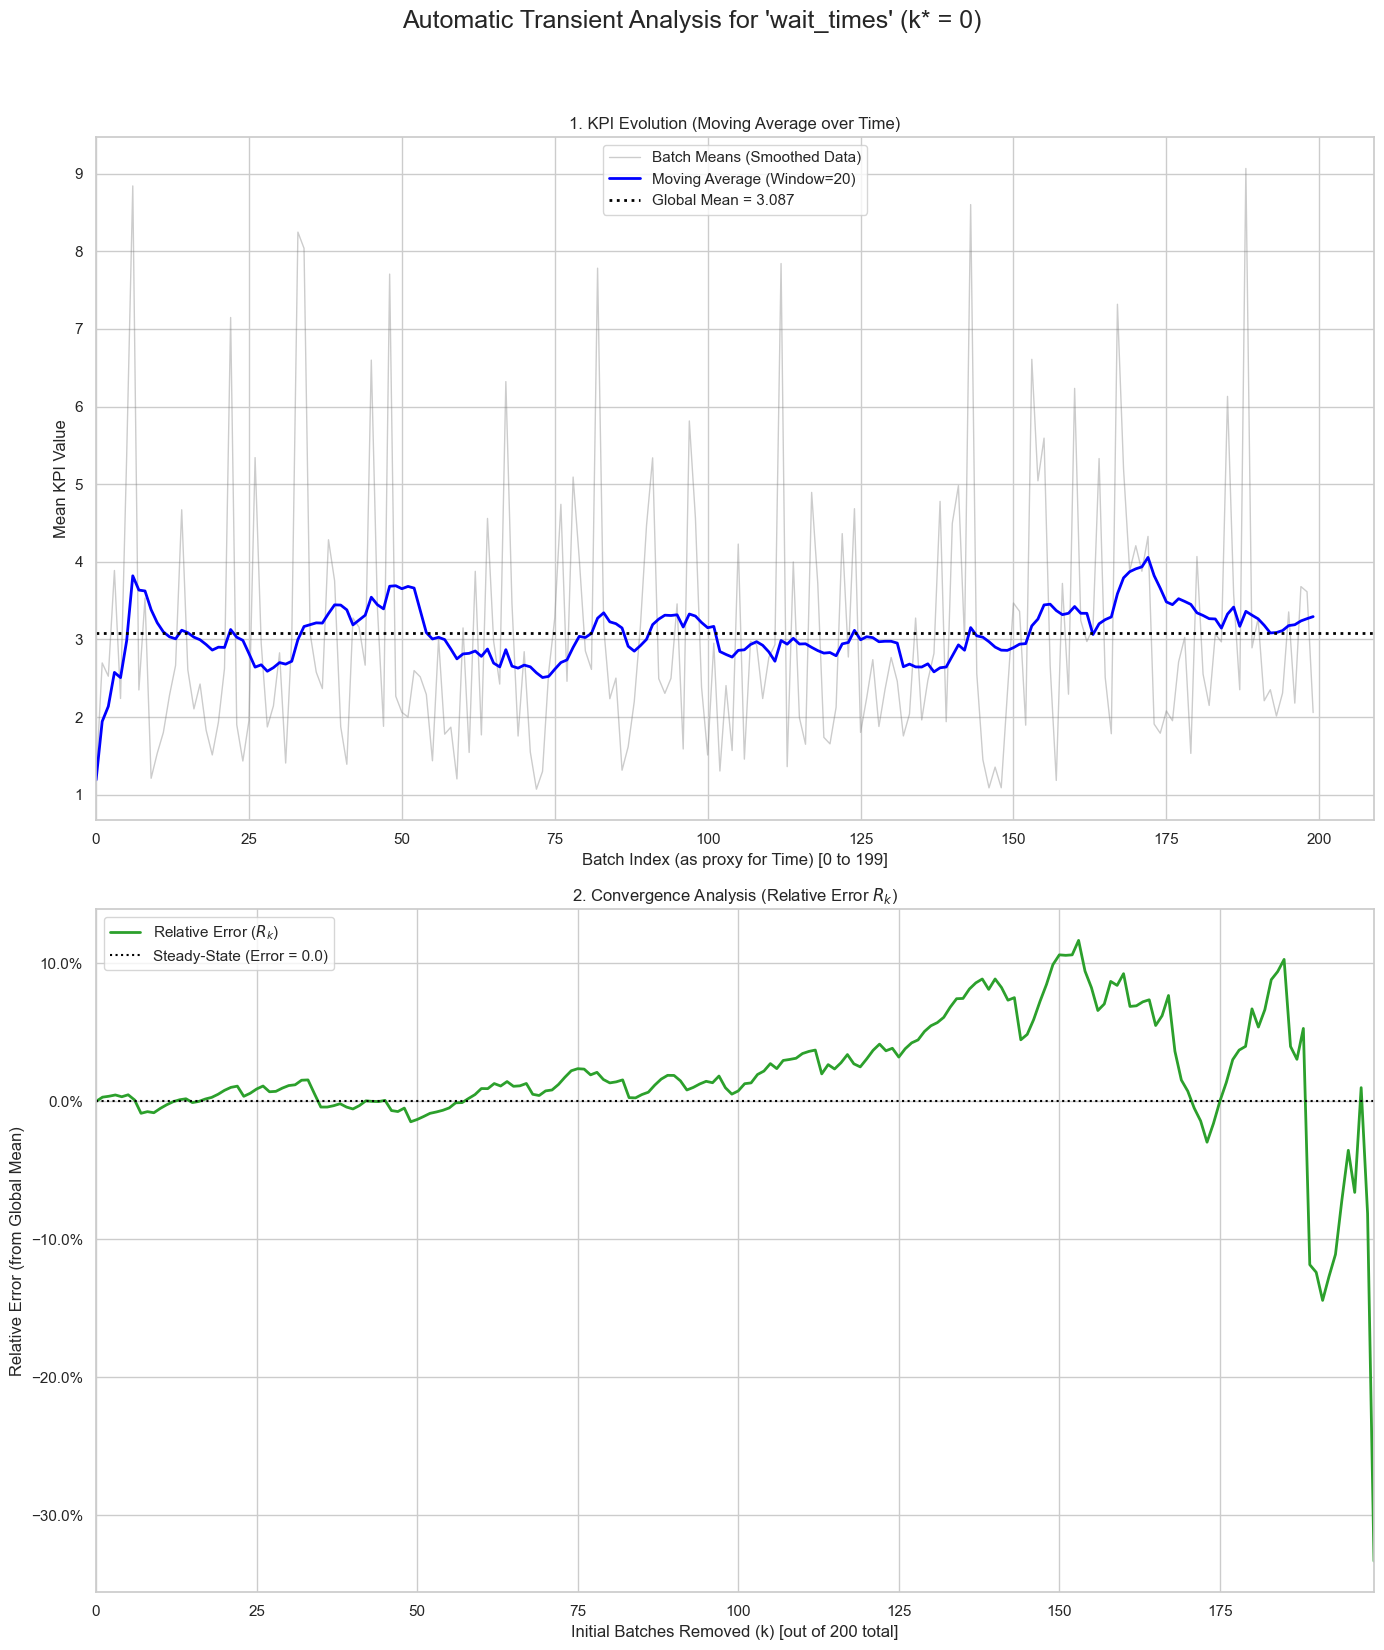

In [13]:
log.info("--- Starting Automatic Transient Analysis ---")

# Define Analysis Parameters
measure_obj = long_run_model.kpi_tracker
kpi_to_analyze = "wait_times" # try "system_times", "service_times"
total_batches = 200

# transient_data contains {'batch_means', 'xk_bar', 'Rk', ...}
log.debug(f"Calculating transient data for '{kpi_to_analyze}'...")
transient_data = calculate_transient_data(
    measure_obj, 
    kpi_key=kpi_to_analyze,
    num_batches=total_batches
)

# FIND k* (Automatically)
# We use our heuristic: k* is where the error |Rk|
# stays below 5% for 5 consecutive batches.
log.debug("Finding k* with heuristic...")
k_star = find_transient_end(
    transient_data,
    threshold=0.05,  # 5%
    patience=5
)

log.info(f"==> Heuristic found transient end at: k* = {k_star} ==")

# Print the key results
global_mean = transient_data['global_mean']
steady_state_mean = transient_data['xk_bar'][k_star]

print(f"Global Mean (with transient): {global_mean:.4f}")
print(f"Steady-State Mean (k*={k_star}): {steady_state_mean:.4f}")

log.debug("Generating plots...")
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 16))
fig.suptitle(
    f"Automatic Transient Analysis for '{kpi_to_analyze}' (k* = {k_star})", 
    fontsize=18, 
    y=1.03
)

# Moving Average (KPI Evolution over Time)
plot_batch_means_over_time(
    transient_data=transient_data,
    t_star_k=k_star,
    moving_avg_window=20,
    ax=axes[0]
)
axes[0].set_title("1. KPI Evolution (Moving Average over Time)")

# Rk (The simplified convergence plot)
plot_transient_analysis(
    transient_data=transient_data, 
    t_star_k=k_star,
    ax=axes[1]
)
axes[1].set_title("2. Convergence Analysis (Relative Error $R_k$)")

fig.tight_layout()
plt.show()

## Conclusion

This notebook successfully demonstrated the `queue_framework`:

* We built a single simulation engine.
* We passed three different, complex queueing models (`FIFO`, `Priority`, `FiniteCapacity`) to that *same* engine.
* The framework correctly handled the state logic for each model.
* The framework correctly tracked and returned detailed KPIs, including the *extended* stats for the specialized models.
* We demonstrated the `analysis` package by running a long simulation, **automatically detecting the transient phase** ($k^*$), and generating plots to visually confirm the end of the warm-up period.

This shows the power of abstraction and the **Strategy Design Pattern** (`BaseQueueModel`). The framework is now verified, showing its capability to handle both state-tracking and advanced statistical analysis, and is ready to be imported into any other project.